<center>
    <h1>Práctica 1 - Parte II. Análisis de datos tabulados: reparto de escaños al Congreso de los Diputados</h1>
    <h3>Programación - Grado en Ciencia de Datos</h3>
    <h3>Universitat Politècnica de València</h3>
</center>

**Práctica realizada por:**
- Nombre de participante Pablo Pertusa Canales

<a id='indice'></a>
## Índice
1. ### [Objetivos](#objetivos)
1. ### [Legislación electoral española: circunscripciones y ley D'Hont](#legislacion_electoral)
1. ### [Funciones para reparto de escaños según la ley D'Hont](#funciones_dhont)
1. ### [Función para mostrar gráficas de resultados electorales](#funcion_resultados)
1. ### [Actividad 1: Cargar datos en un dataframe](#act1)
1. ### [Actividad 2: Porcentaje de participación por circunscripción](#act2)
1. ### [Actividad 3: Número de escaños por circunscripción ](#act3)
1. ### [Actividad 4: Número de escaños por comunidad](#act4)
1. ### [Actividad 5: Resultados por circunscripción](#act5)
1. ### [Actividad 6: Resultados para el congreso de los diputados](#act6)
1. ### [Actividad 7: Coste en votos de cada escaño](#act7)

<a id='objetivos'></a>
## Objetivos:
- Aprender a analizar y visualizar datos tabulados (estructurados en filas y columnas) mediante la realización de operaciones básicas (ordenación, selección, agrupamiento, agregación, ...)
- Aprender a usar los tipos de datos **DataFrame** y **Series** de la biblioteca pandas.
- Usar la librería **matplotlib.pyplot** para representar gráficamente los datos del estudio.

<a id='legislacion_electoral'></a>
## Legislación electoral española: división en circunscripciones y asignación de diputados mediante la Ley D'Hont

El congreso se compone de 350 diputados, que representan a 52 **circunscripciones** (las 50 provincias de España más las ciudades autónomas de Ceuta y Melilla). Cada circunscripción aporta un número de diputados. Concretamente, Ceuta y Melilla aportan un diputado cada una, y el resto de provincias lo hace en proporción a su población, con un mínimo de dos diputados. Por ejemplo, Madrid aporta 31 diputados, Valencia 16 o Soria 2.

En España se utiliza la **ley D'Hont** para asignar los diputados (o escaños) que le corresponden a cada partido en función de los votos obtenidos. Para ello, en primer lugar se excluye de cada circunscripción a las candidaturas que no hayan obtenido al menos un 3% de los votos válidos (votos a candidaturas + votos en blanco). A continuación, el reparto se hace siguiendo el siguiente algoritmo:

Se crea una tabla con tantas filas como partidos con opción a escaño y tantas columnas como escaños a repartir. En la primera columna se almacena el número de votos obtenido por cada partido, en la segunda el número de votos dividido entre dos, en la tercera el número de votos entre tres, y así sucesivamente. A continuación se obtienen los n valores máximos de esta tabla, siendo n el número de escaños a repartir. Por cada uno de estos máximos, se asigna un escaño al partido correspondiente. En la siguiente figura se muestra un ejemplo, en el que el partido A obtendría 2 diputados, el B otros 2 y el C 1.

![Figura reparto escaños](reparto_escanos.gif)

[Volver al índice](#indice)

<a id='funciones_dhont'></a>
## Funciones para realizar el reparto de escaños según la ley D'Hont

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 0

def reparto_escaños(votos_validos, tot_escaños, votos_partidos, porcentaje_min=3):
    """
    Hace el reparto de escaños aplicando la Ley D'Hont.
    Parámetros de entrada:
       - votos_validos: número de votos válidos (votos a candidatura + votos en blanco)
       - tot_escaños: número de escaños a repartir
       - votos_partidos: diccionario del tipo {'Nombre partido':votos obtenidos}
       - porcentaje_min: porcentaje mínimo de votos para que una candidatura tenga opción a escaño
    Devuelve:
       - diccionario del tipo {'Nombre partido':diputados asignados}
    """
    # En primer lugar determinar las candidaturas que han superado un procentaje mínimo de votos:
    candidatos = []
    for partido,votos in votos_partidos.items():
        if votos * 100 / votos_validos >= porcentaje_min:
            candidatos.append(partido)

    # Creamos una lista auxiliar en la que pondremos tuplas (votos/i, partido) con i: 1..tot_escaños
    aux = []
    for partido in candidatos:
        for i in range(tot_escaños):
            aux.append((votos_partidos[partido]/(i+1),partido))

    # Ordenamos la lista aux de mayor a menor:
    aux.sort(reverse=True)

    # Tomamos las 'tot_escaños' primeras tuplas de aux y creamos el diccionario 'resultado'
    resultado = {}
    for score,partido in aux[:tot_escaños]:
        resultado[partido] = resultado.get(partido,0) + 1

    return resultado                  

<a id='funcion_resultados'></a>
## Función para mostrar los diputados obtenidos por cada candidatura

In [12]:
def get_color(partido):
    dic_colores = {'PSOE':'red', 'PP':'blue', "C's":'darkorange', "Cs":'darkorange',
                   'UP':'darkmagenta', 'ERC':'orange', 'VOX':'limegreen', 'PNV':'green'}
    # si el partido está en el diccionario devolvemos su color:
    if partido in dic_colores:
        return dic_colores[partido]
    # a lo mejor está con algún prefijo o sufijo de la comunidad o provincia...
    for clave in dic_colores:
        if partido in clave or clave in partido:
            return dic_colores[clave]
    # si no está, valor por defecto:
    return 'gray'
    
def plot_escaños(dic_partidos_escaños): 
    """
    Muestra los diputados obtenidos por cada candidatura.
    Parámetros de entrada:
       - dic_partidos_escaños: diccionario del tipo {'Nombre partido':diputados asignados} 
                               (esto es, valor devuelto por la función reparto_escanyos)
    """
    # Creamos una lista de los partidos ordenada por el nº escaños, para ello
    # primero hacemos una lista con pares (escaños,partido):
    aux = []
    for part,esc in dic_partidos_escaños.items():
        aux.append( (esc,part))
    aux.sort(reverse=True) # ordenamos de mayor a menor
    
    # y los ponemos en 2 listas junto a una lista de colores de cada partido:
    escaños, partidos, colores = [], [], []
    for esc,part in aux:
        escaños.append(esc)
        partidos.append(part)
        colores.append( get_color(part) )
    
    # la figura tendrá 2 gráficas en 1 fila y 2 columnas:
    fig, ax = plt.subplots(ncols=2, figsize=(12, 3))
    
    # MOSTRAR GRAFICA DE TARTA (subfigura 1)
    
    # Eliminar labels de partidos con poca representación ya que no caben todas en el gráfico de tarta
    labels = partidos.copy() # empezamos con una copia
    tot_escaños = sum(escaños)
    for i in range(len(labels)):
        if escaños[i]/tot_escaños < 0.02: # Borrar etiqueta de partidos con menos de un 2% de escaños
            labels[i] = ''
            
    def porcentaje(val): # funcion auxiliar para dibujar
        if val > 5:
            return int(np.round(val/100.0* tot_escaños,0))
        else:
            return ""
        
    ax[0].pie(escaños, labels=labels, colors=colores, autopct=porcentaje)
        
    # Dibujar circulo en el centro para hacer un donut
    centre_circle = plt.Circle((0,0),0.45,color='black', fc='white')
    fig = plt.gcf()
    ax[0].add_artist(centre_circle)

    # Establecer aspect ratio 'equal' para que tenga forma de círculo y no de ovalo
    ax[0].axis('equal')
    
    # MOSTRAR GRAFICA DE BARRAS (subfigura 2)
    for i, v in enumerate(escaños):
        ax[1].text(i-0.1, v + 0.1, str(v))
        
    ax[1].bar(partidos, escaños, alpha=1, color=colores)
    ax[1].tick_params(axis='x',rotation=25)
    ax[1].set_yticks(range(1, max(escaños)+2))
    ax[1].set_yticklabels([])
    plt.show() # this will load image to console before executing next line of code    

<a id='act1'></a>
## ACTIVIDAD 1: Cargar datos en un DataFrame

Almacena el fichero "resultados_elecciones_2019.csv" en un dataframe de pandas y muestra las 5 primeras filas. El fichero utiliza como separador de campos el punto y coma, por lo que tendrás que especificar la opción sep=';' para leer correctamente el fichero.

*Fuente del archivo de datos: [http://www.infoelectoral.mir.es/infoelectoral/min/areaDescarga.html?method=inicio](http://www.infoelectoral.mir.es/infoelectoral/min/areaDescarga.html?method=inicio)*

[Volver al índice](#indice)

In [4]:
import pandas as pd
df = pd.read_csv('resultados_elecciones_2019.csv',delimiter=';')
df.head()

,Nombre de Comunidad,Código de Provincia,Nombre de Provincia,Escaños,Población,Número de mesas,Total censo electoral,Total votantes,Votos válidos,Votos a candidaturas,...,UNIÓN REGIONALISTA,Canda,FIA,SOLIDARIA,RISA,centrados,DPL,IZAR,C 21,UDT
0,Andalucía,4,Almería,6,709340,809,502627,305414,302424,299763,...,0,0,0,0,0,0,0,0,0,0
1,Andalucía,11,Cádiz,9,1238714,1520,1002295,624195,616079,606858,...,0,0,0,0,0,0,0,0,0,0
2,Andalucía,14,Córdoba,6,785240,935,648341,451775,444376,438971,...,0,0,0,0,0,0,0,0,0,0
3,Andalucía,18,Granada,7,912075,1100,755007,490902,482779,478251,...,0,520,0,0,0,0,0,113,0,0
4,Andalucía,21,Huelva,5,519932,650,399019,255329,250681,247336,...,0,0,0,0,0,0,0,0,0,0


<a id='act2'></a>
## ACTIVIDAD 2: Porcentaje de participación por circunscripción (provincia)

**Conceptos a trabajar:**
- Añadir nuevas columnas a un dataframe
- Ordenar un dataframe
- Mostrar gráfico de barras con las etiquetas de una columna y los datos de otra

Consulta cómo hacer estas operaciones en el tutorial `pandas_dataframe.ipynb` disponible en PoliformaT sección Tutoriales.

**Tareas a realizar:**
1. A partir de las columnas 'Total censo electoral' y 'Total votantes', crea una nueva columna en el dataframe para almacenar el porcentaje de participación en cada circunscripción.
1. Ordena las filas del dataframe según el valor de esta nueva columna
1. Crea un gráfico de barras horizontal con el método ax.barh, en el que el primer parámetro deberá ser los valores de la columna 'Nombre de Provincia' y el segundo los valores de la nueva columna con los porcentajes de participación.
1. Personaliza la figura:
    - Cuando crees la figura con `plt.subplots` añade el parámetro `figsize=(10,25)` para adecuar el tamaño de la misma.
    - Usa el método `ax.grid(axis='x')` para mostrar las líneas verticales de una rejilla.
    - Añade un título a la gráfica.
    
[Volver al índice](#indice)     

In [5]:
e = df.loc[:,'Total censo electoral']
ev = e.values
v = df.loc[:,'Total votantes']
vv = v.values
a = 0
l = []
for i in vv:
    p = (i/ev[a])*100
    l += [p]
    a += 1
df['Porcentaje de participación'] = l
df.sort_values(by='Porcentaje de participación',ascending=False,inplace=True)
df

,Nombre de Comunidad,Código de Provincia,Nombre de Provincia,Escaños,Población,Número de mesas,Total censo electoral,Total votantes,Votos válidos,Votos a candidaturas,...,Canda,FIA,SOLIDARIA,RISA,centrados,DPL,IZAR,C 21,UDT,Porcentaje de participación
26,Castilla y León,47,Valladolid,5,519851,769,432655,314787,311454,308307,...,0,0,0,0,0,0,0,0,0,72.757047
24,Castilla y León,40,Segovia,3,153342,319,119492,86451,85039,84034,...,0,0,0,0,234,0,0,0,0,72.348776
16,Castilla - La Mancha,16,Cuenca,3,197222,383,154441,110537,109119,108117,...,0,0,0,0,0,0,0,0,0,71.572316
17,Castilla - La Mancha,19,Guadalajara,3,254308,523,187371,133796,132154,131006,...,0,0,0,0,0,0,0,0,0,71.406995
38,Comunitat Valenciana,46,Valencia / València,15,2547986,3107,1970196,1402405,1390258,1379460,...,0,0,0,0,0,0,0,0,0,71.180989
37,Comunitat Valenciana,12,Castellón / Castelló,5,576898,715,420741,297492,294469,292231,...,0,0,0,0,0,0,0,0,0,70.706682
34,Comunidad de Madrid,28,Madrid,37,6578079,7564,5088093,3591464,3563147,3534364,...,0,0,0,0,0,0,0,0,0,70.585659
5,Andalucía,23,Jaén,5,638099,892,526659,371043,365106,361745,...,0,0,0,249,0,0,0,0,0,70.452228
18,Castilla - La Mancha,45,Toledo,6,687391,926,525752,368619,363474,360813,...,0,0,0,0,0,0,0,0,0,70.112715
28,Cataluña,8,Barcelona,32,5609350,5985,4201151,2942354,2927755,2907298,...,0,0,0,0,0,0,0,0,0,70.036854


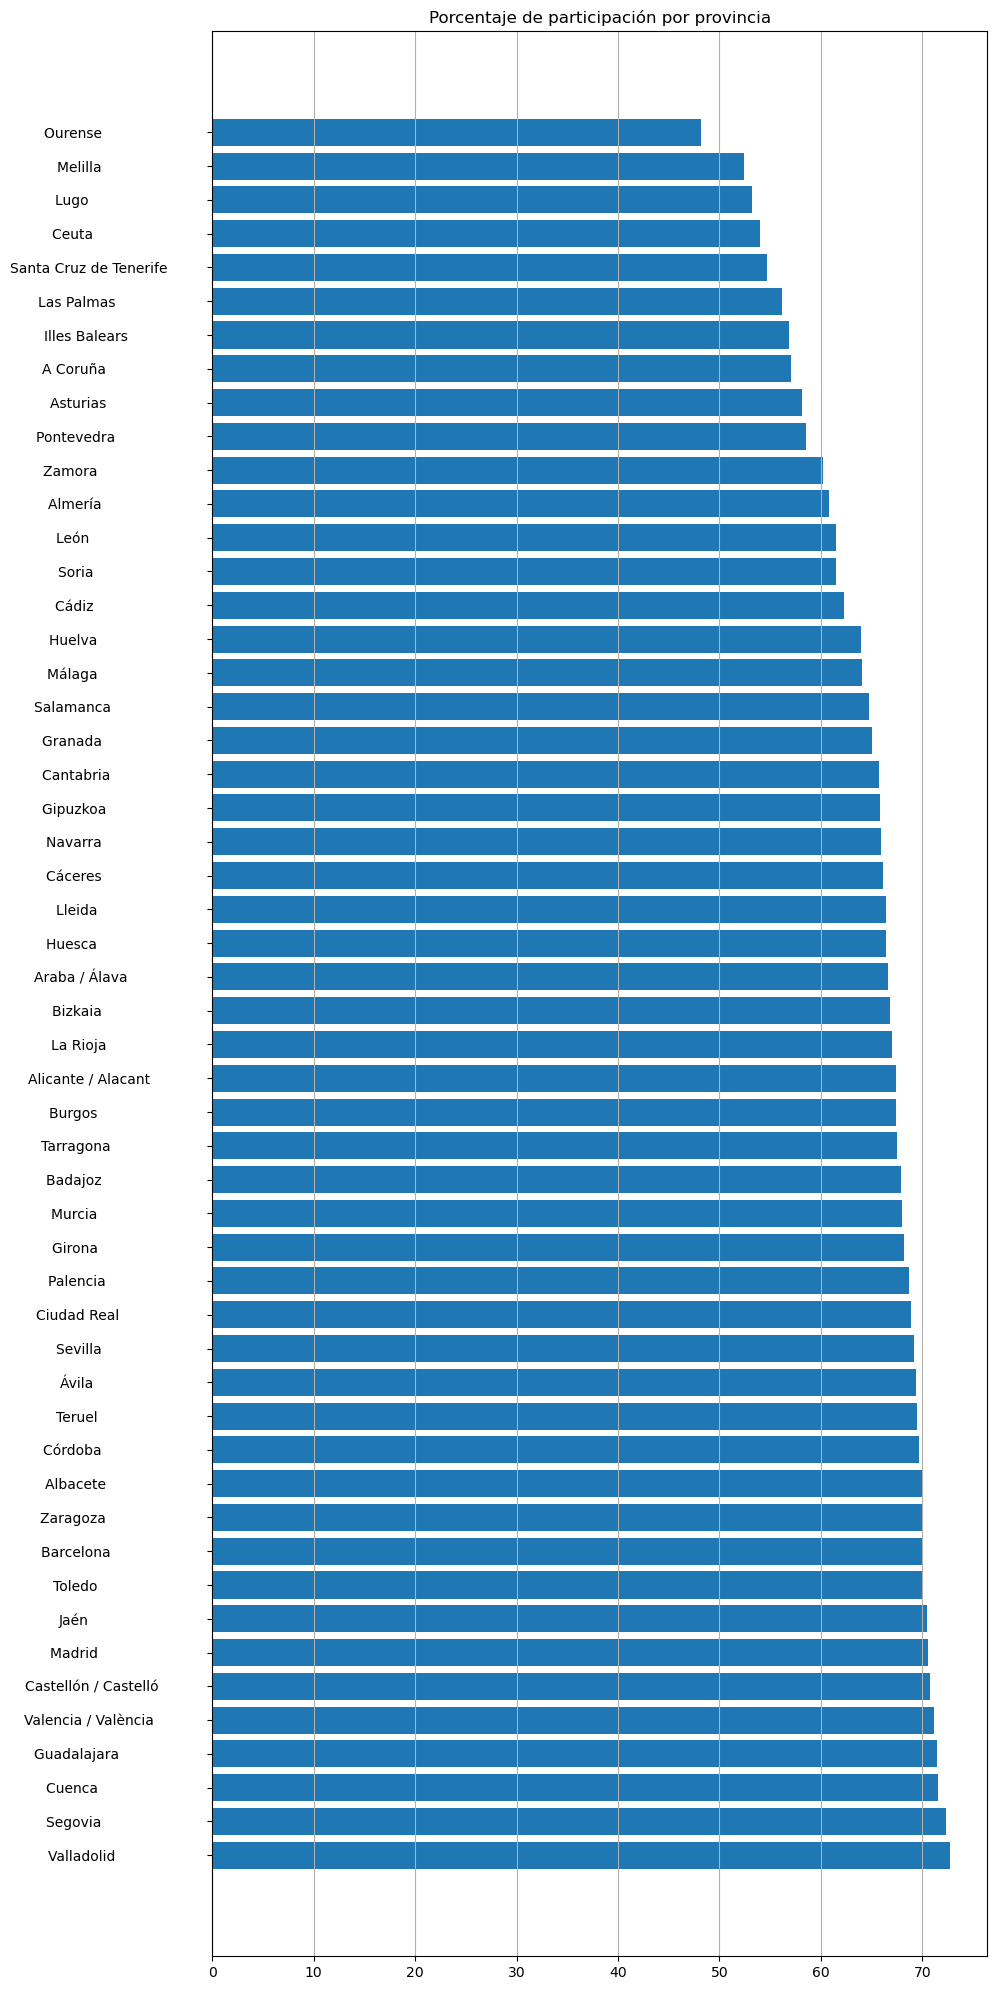

In [6]:
np = df['Nombre de Provincia']
np.values
pp = df['Porcentaje de participación']
pp.values
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,25))
ax.barh(np.values,pp.values)
ax.grid(axis='x')
ax.set_title('Porcentaje de participación por provincia')
None

<a id='act3'></a>
## ACTIVIDAD 3: Número de escaños por circunscripción (provincia)

**Conceptos a trabajar:**
- Reforzar los mismos conceptos trabajados en la actividad 2

**Tareas a realizar:**

- Muestra una gráfica similar a la de la actividad 2, en este caso con el número de escaños a repartir en cada circunscripción. Ordena los datos en función de dicho número de escaños.

[Volver al índice](#indice)

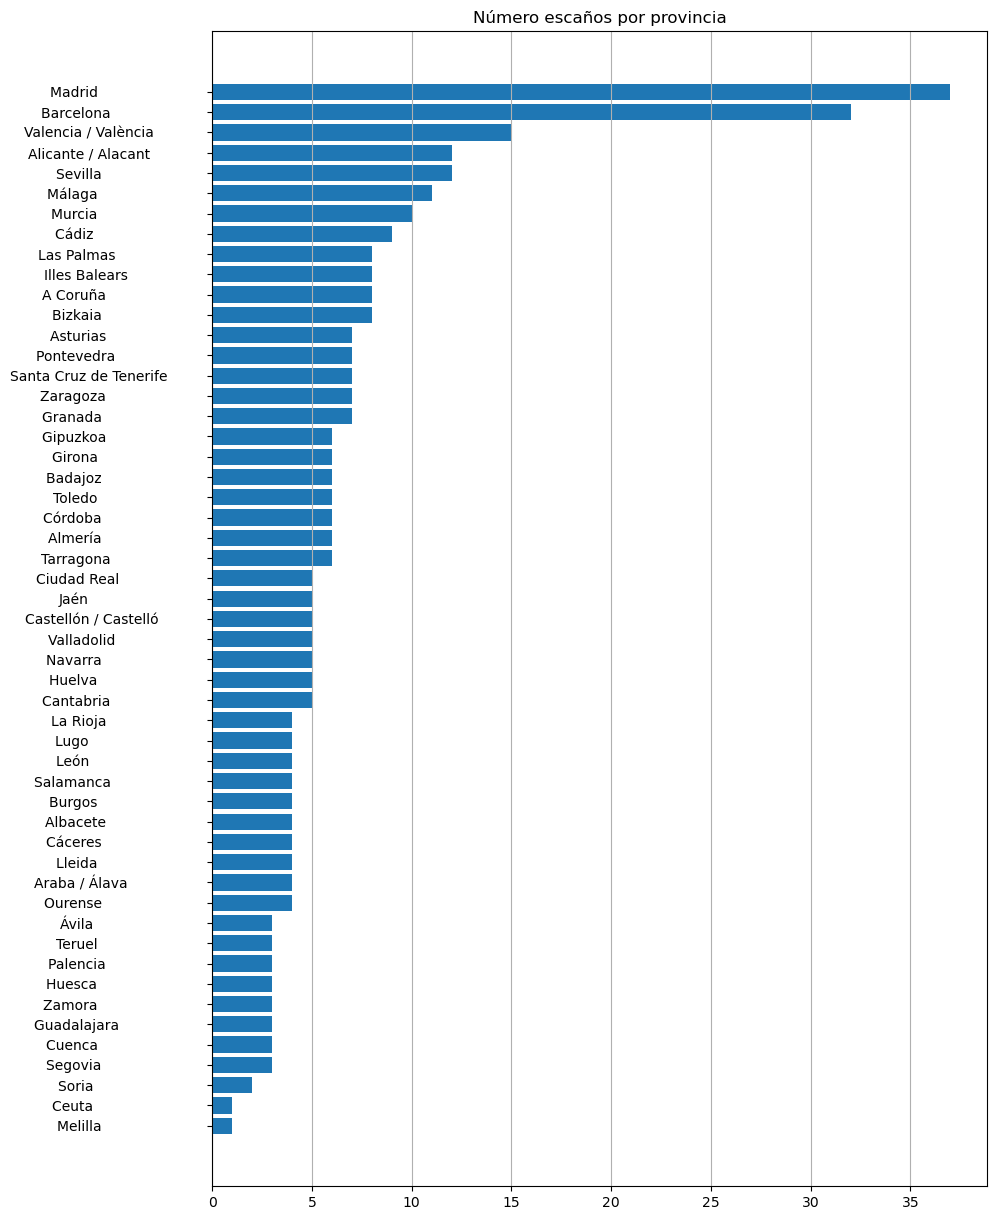

In [7]:
df.sort_values(by='Escaños',ascending=True, inplace=True)
esc = df['Escaños']
np = df['Nombre de Provincia']
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(np.values,esc.values)
ax.set_title('Número escaños por provincia')
ax.grid(axis = 'x')
None

<a id='act4'></a>
## ACTIVIDAD 4: Número de escaños por comunidad

**Conceptos a trabajar:**
- Agrupar datos

Consulta cómo hacer estas operaciones en el tutorial `pandas_dataframe.ipynb` mencionado anteriormente.

**Tareas a realizar:**
- Muestra una gráfica similar a la de la actividad 3, pero mostrando en este caso el número total de escaños por Comunidad Autónoma. Para ello debrás utilizar la función `groupby` para agrupar filas en función de la Comunidad, junto con la función `sum` para obtener la suma de escaños en cada comunidad.

[Volver al índice](#indice)

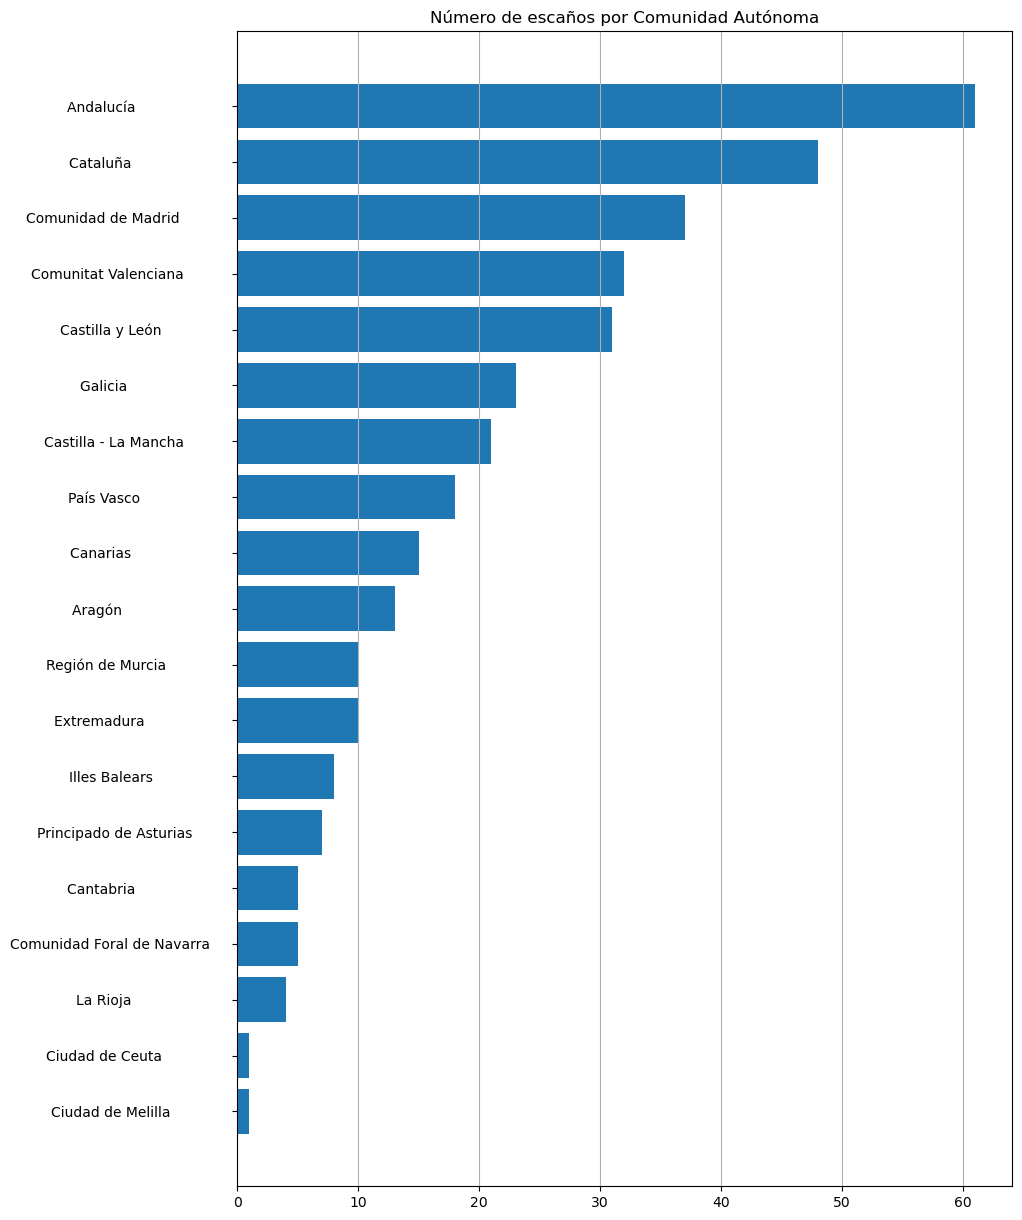

In [8]:
se = df.groupby('Nombre de Comunidad').sum()['Escaños']
s = se.sort_values(ascending=True)
com = s.index
n = s.values
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(com,s)
ax.grid(axis = 'x')
ax.set_title('Número de escaños por Comunidad Autónoma')
None

<a id='act5'></a>
## ACTIVIDAD 5: Resultados por circunscripción

**Conceptos a trabajar:**
- Iterar sobre las filas de un dataframe

**Tareas a realizar:**

Muestra, para cada provincia (circunscripción) una gráfica con el reparto de escaños en dicha provincia. Observa que cada fila del dataframe corresponde a una provincia distinta, por lo que será necesario iterar sobre cada fila para realizar esta operación. Esto puede hacerse con el bucle:

`for index, row in df.iterrows():`

donde `row` será un objeto de tipo `Series` con el contenido de cada fila.

Para cada fila:
1. Obtén el nombre de la provincia, los votos válidos y el número de escaños
1. Crea un diccionario donde las claves sean los nombres de los partidos y los valores los votos obtenidos
1. Obtén la asignación de escaños invocando adecuadamente al método reparto_escaños
1. Muestra un texto con el nombre de la provincia y el total de escaños a repartir y a continuación muestra la gráfica con los resultados invocando adecuadamente al método plot_escaños

[Comprueba que tus resultados coinciden con los publicados en este enlace](http://resultados-elecciones.rtve.es/generales/2019/congreso/)

[Volver al índice](#indice)

Melilla                       1 escaños a repartir


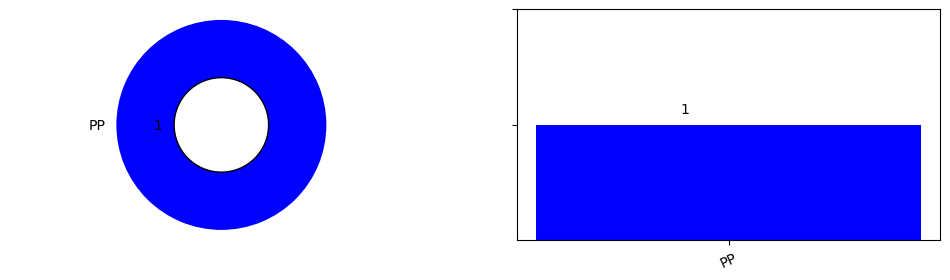

Ceuta                         1 escaños a repartir


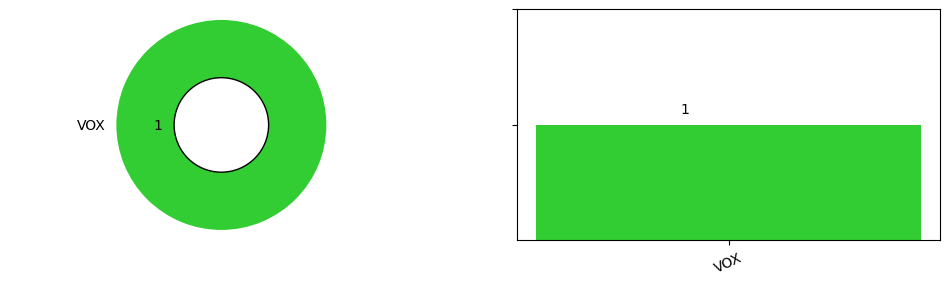

Soria                         2 escaños a repartir


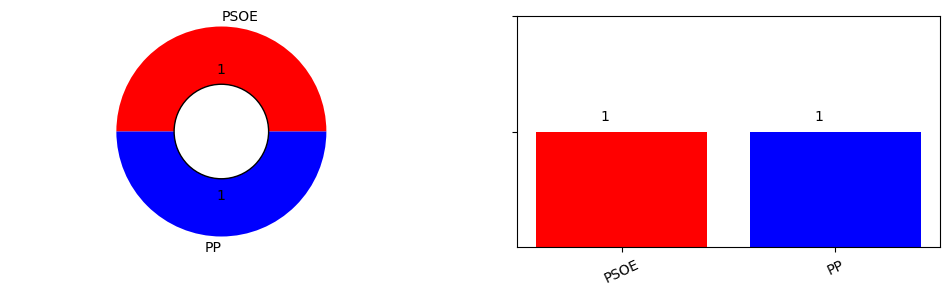

Segovia                       3 escaños a repartir


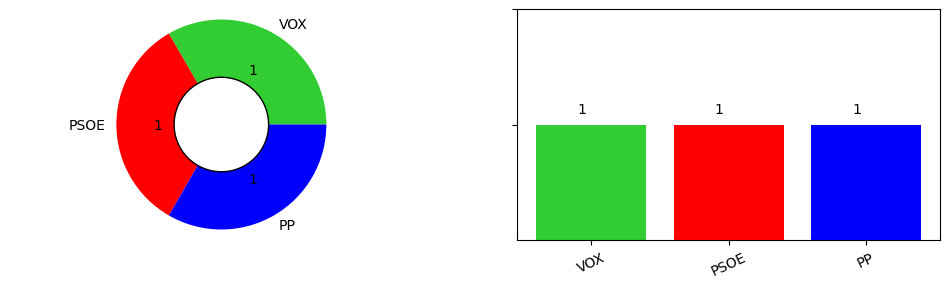

Cuenca                        3 escaños a repartir


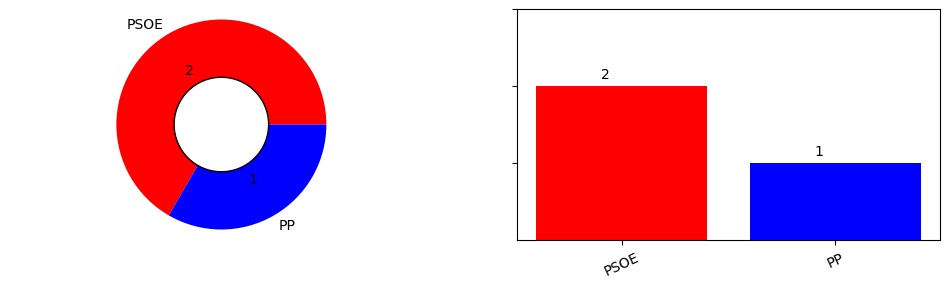

Guadalajara                   3 escaños a repartir


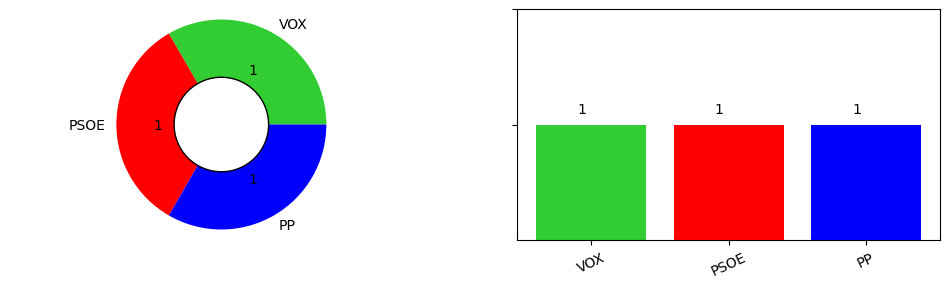

Zamora                        3 escaños a repartir


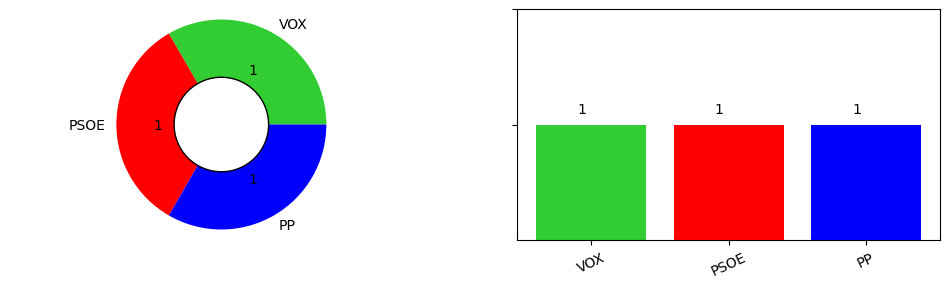

Huesca                        3 escaños a repartir


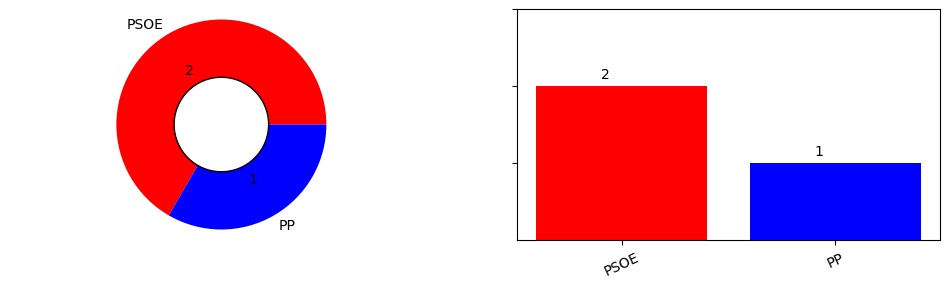

Palencia                      3 escaños a repartir


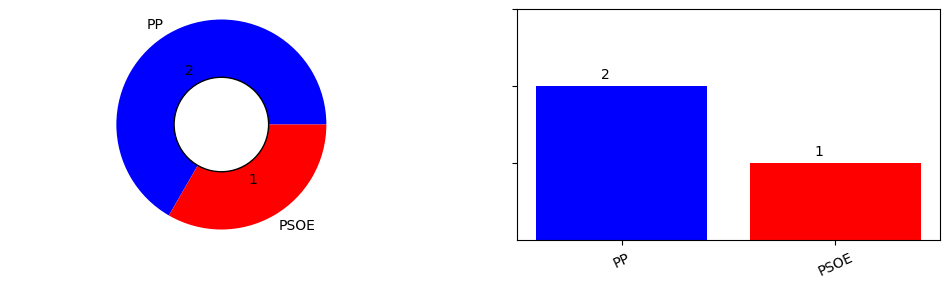

Teruel                        3 escaños a repartir


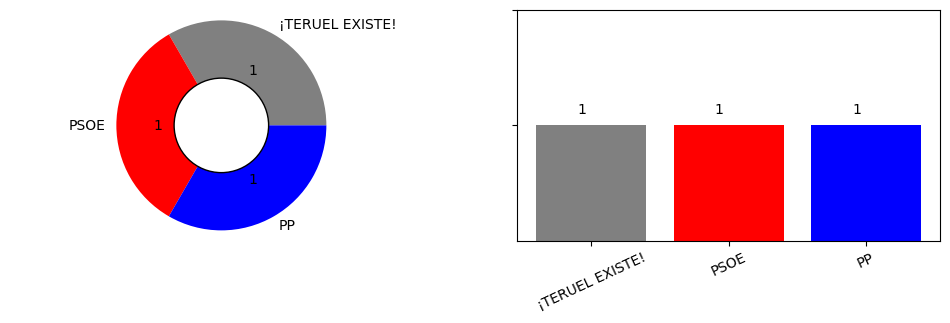

Ávila                         3 escaños a repartir


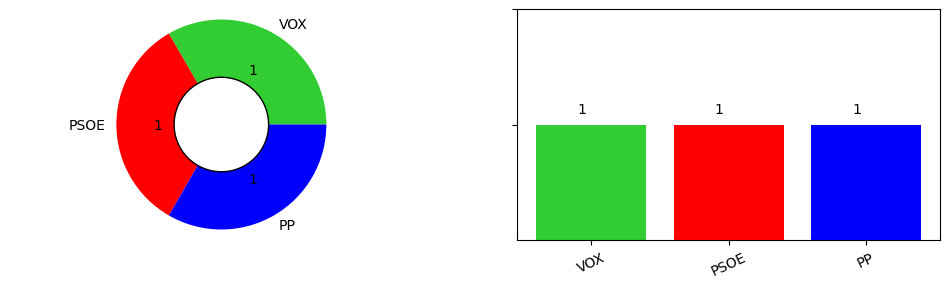

Ourense                       4 escaños a repartir


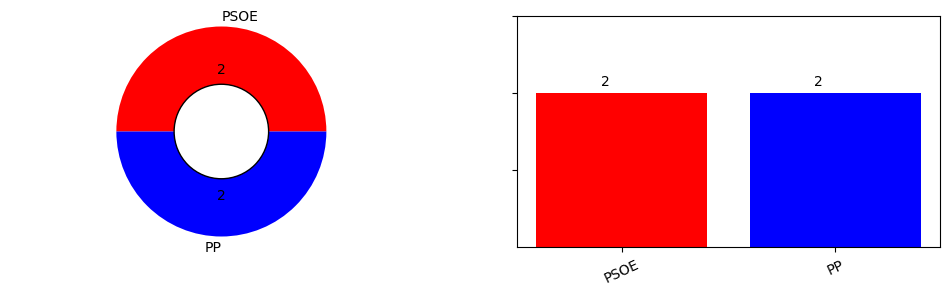

Araba / Álava                 4 escaños a repartir


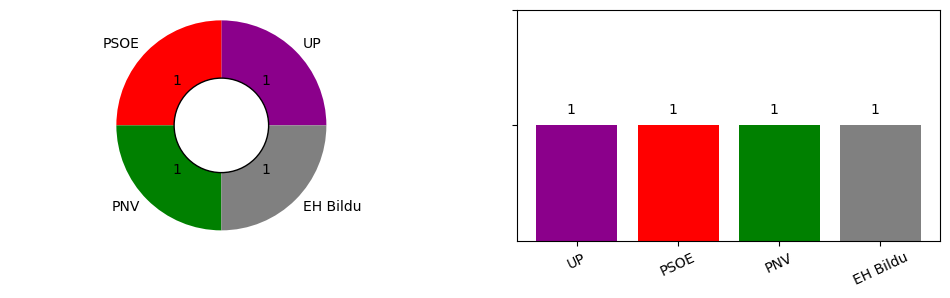

Lleida                        4 escaños a repartir


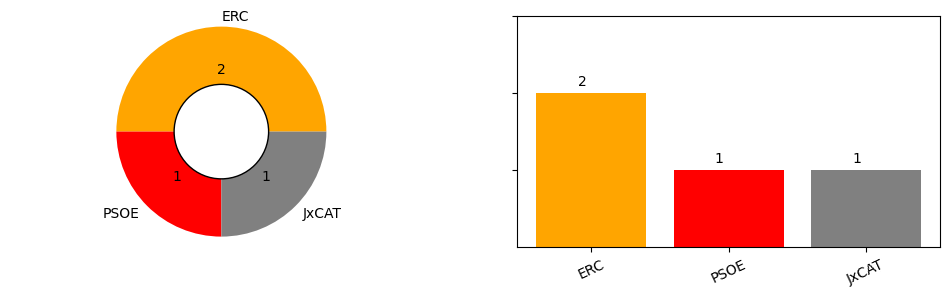

Cáceres                       4 escaños a repartir


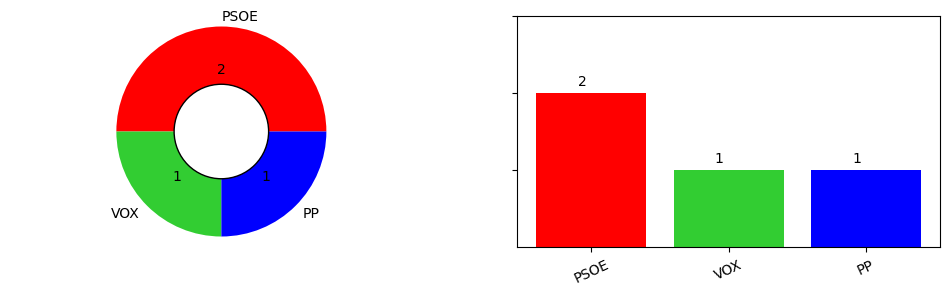

Albacete                      4 escaños a repartir


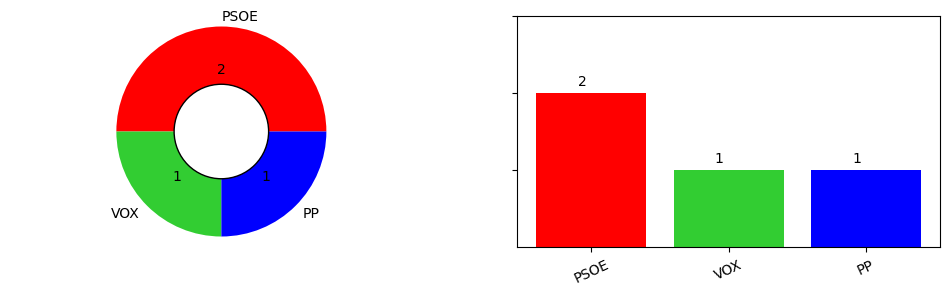

Burgos                        4 escaños a repartir


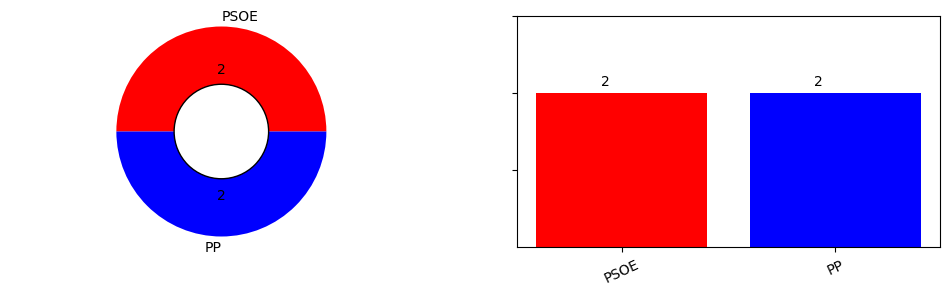

Salamanca                     4 escaños a repartir


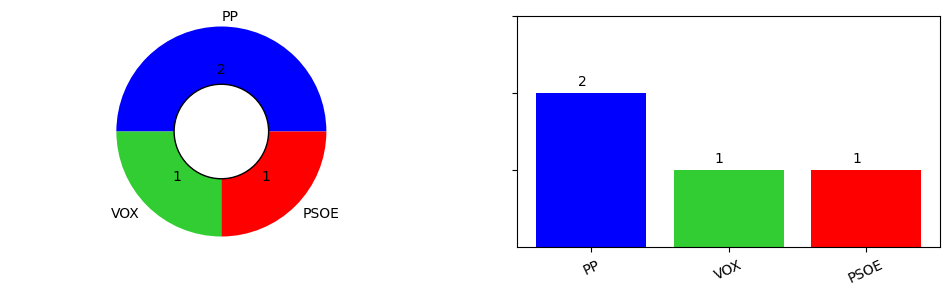

León                          4 escaños a repartir


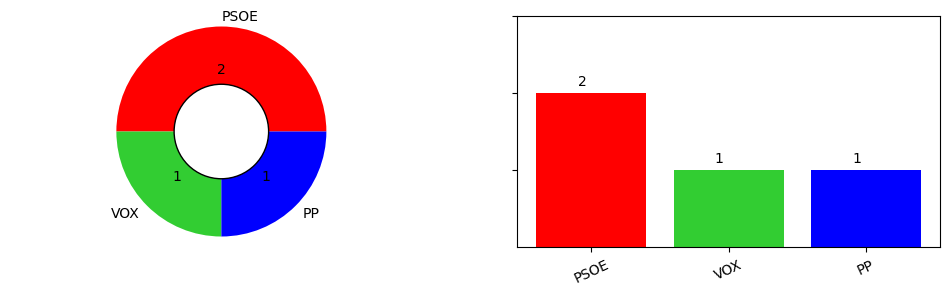

Lugo                          4 escaños a repartir


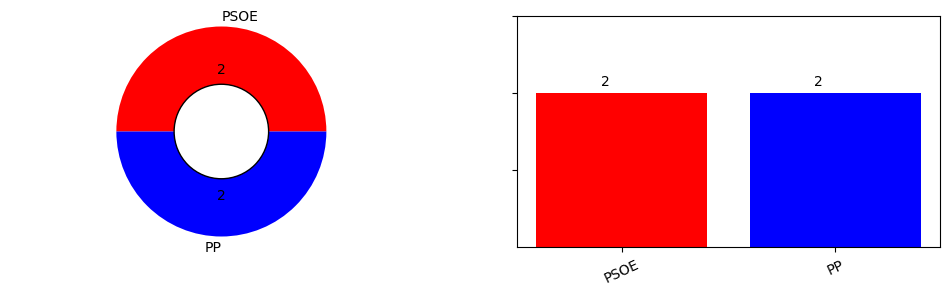

La Rioja                      4 escaños a repartir


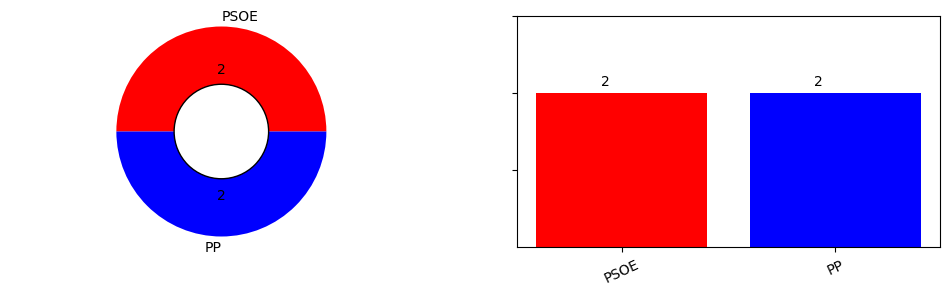

Cantabria                     5 escaños a repartir


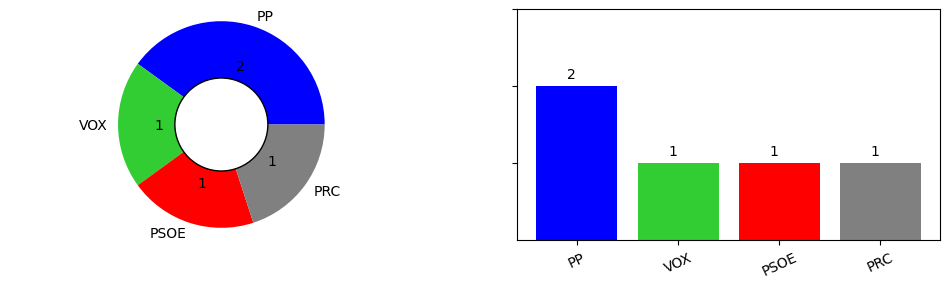

Huelva                        5 escaños a repartir


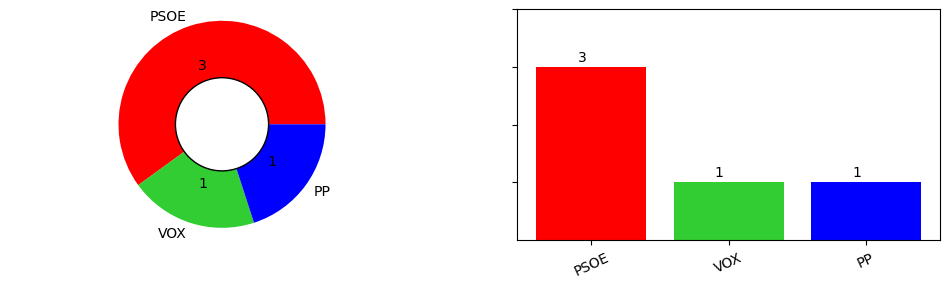

Navarra                       5 escaños a repartir


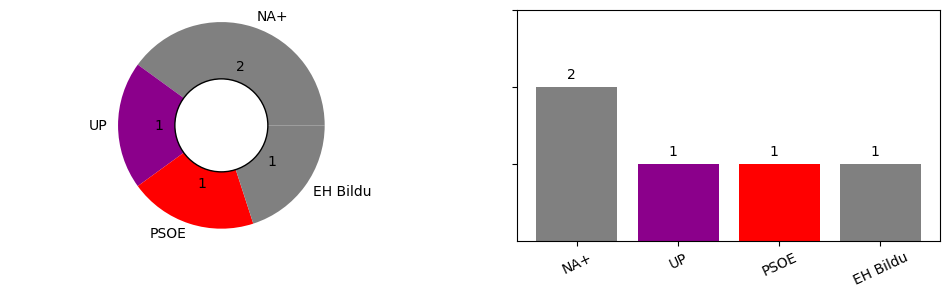

Valladolid                    5 escaños a repartir


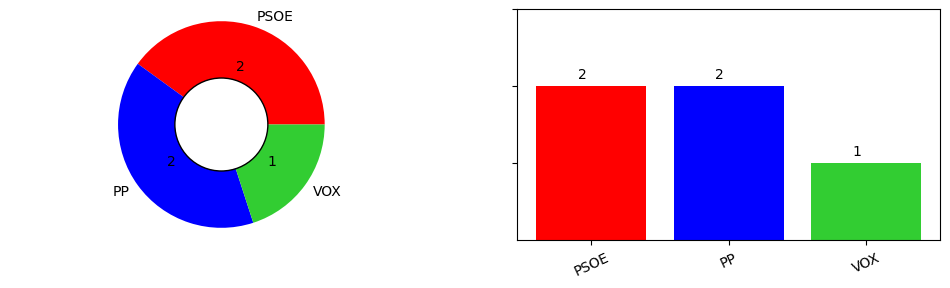

Castellón / Castelló          5 escaños a repartir


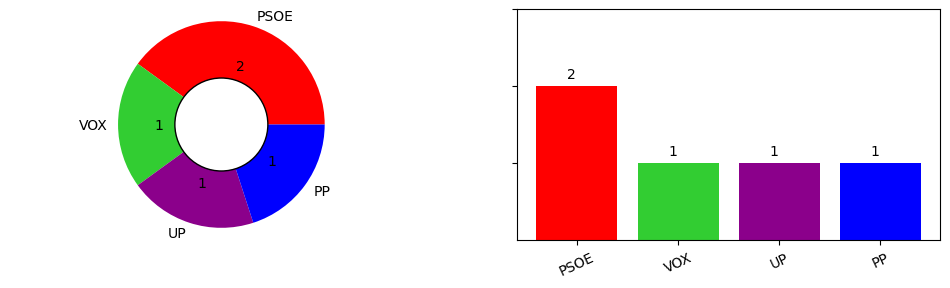

Jaén                          5 escaños a repartir


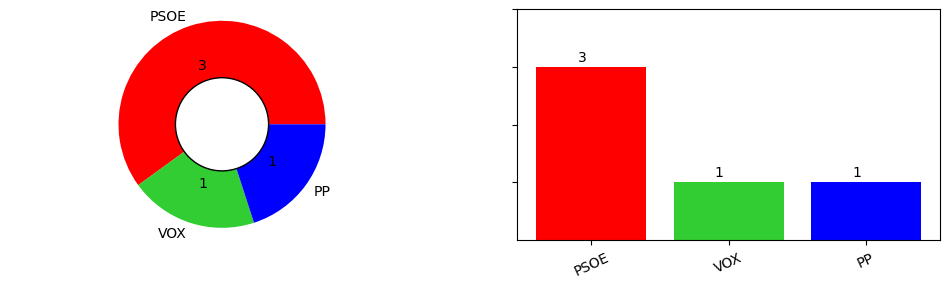

Ciudad Real                   5 escaños a repartir


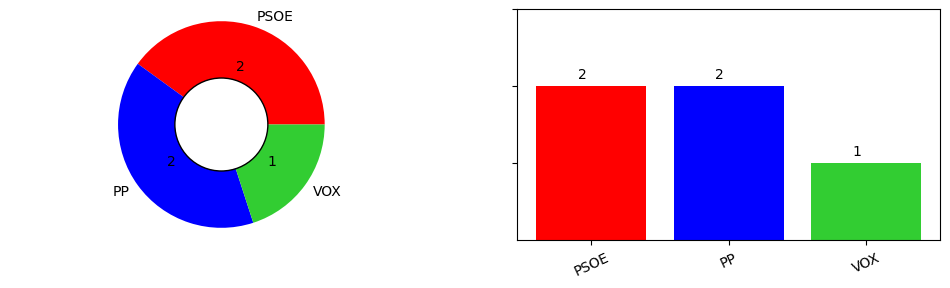

Tarragona                     6 escaños a repartir


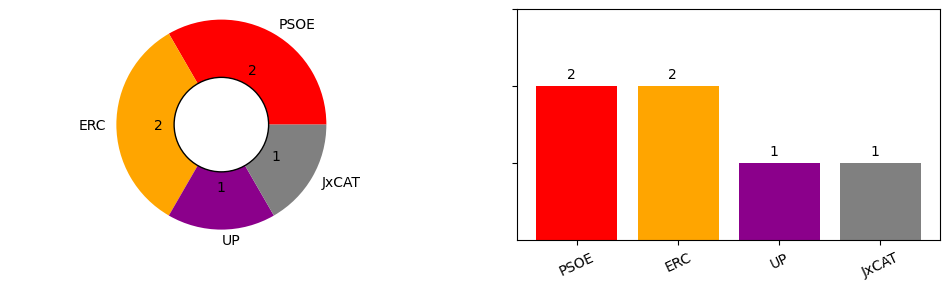

Almería                       6 escaños a repartir


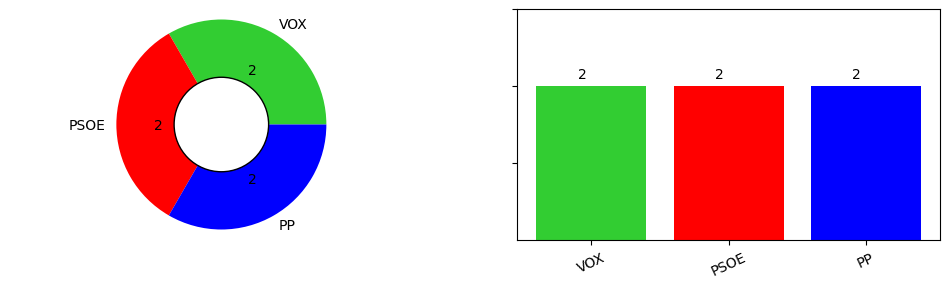

Córdoba                       6 escaños a repartir


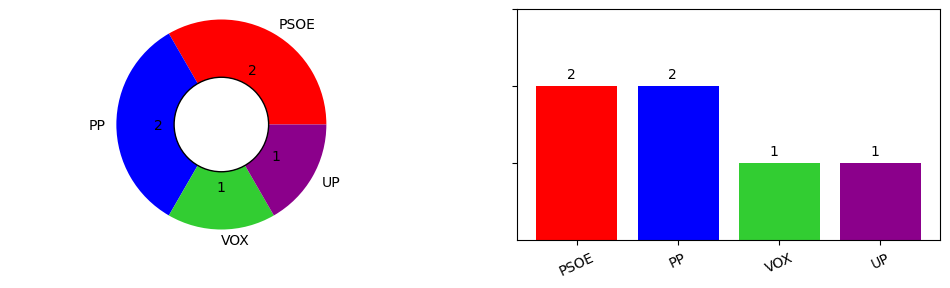

Toledo                        6 escaños a repartir


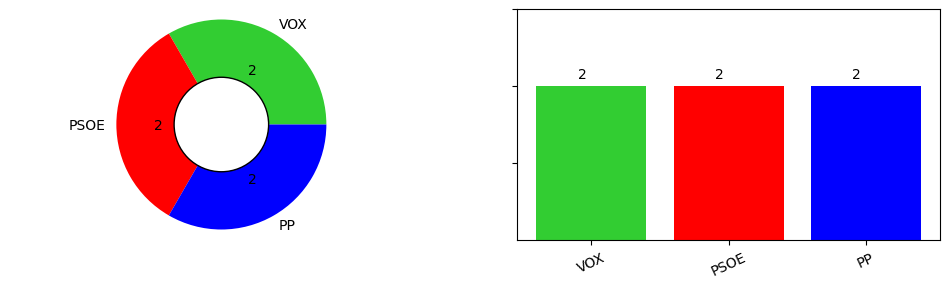

Badajoz                       6 escaños a repartir


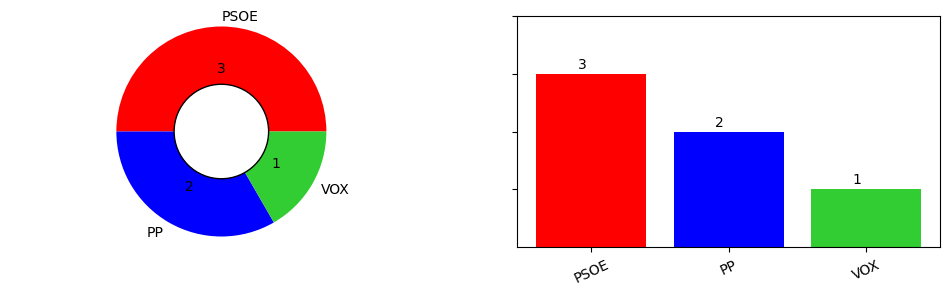

Girona                        6 escaños a repartir


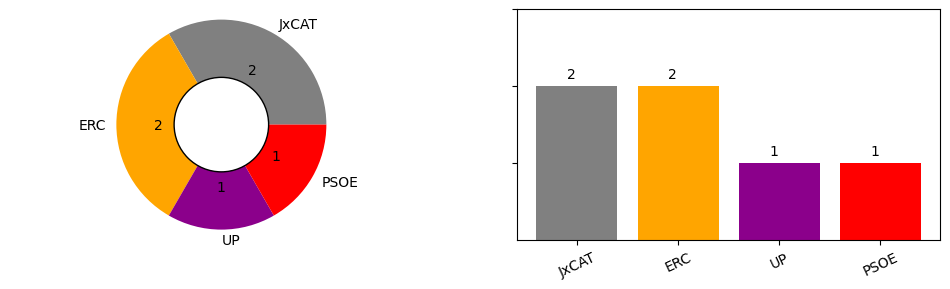

Gipuzkoa                      6 escaños a repartir


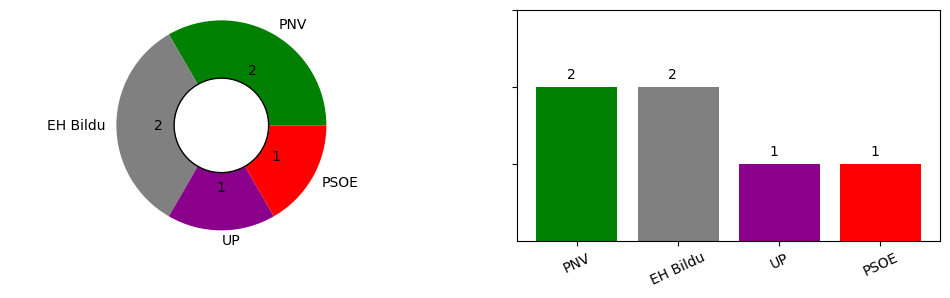

Granada                       7 escaños a repartir


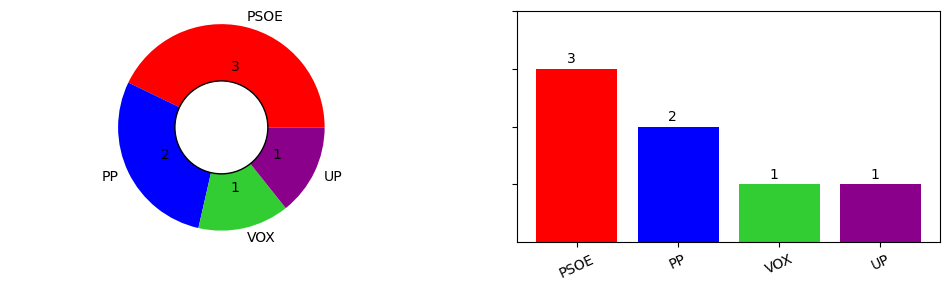

Zaragoza                      7 escaños a repartir


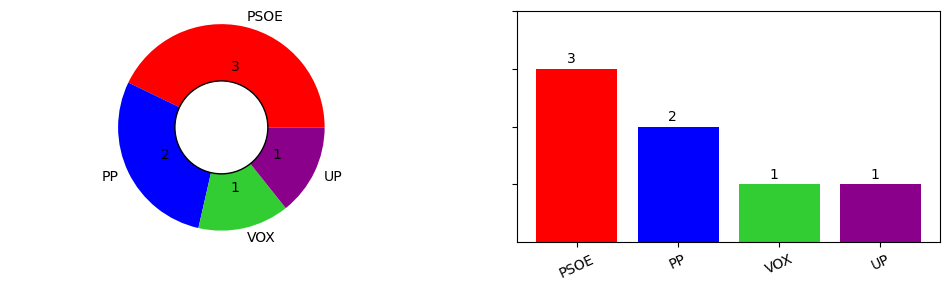

Santa Cruz de Tenerife        7 escaños a repartir


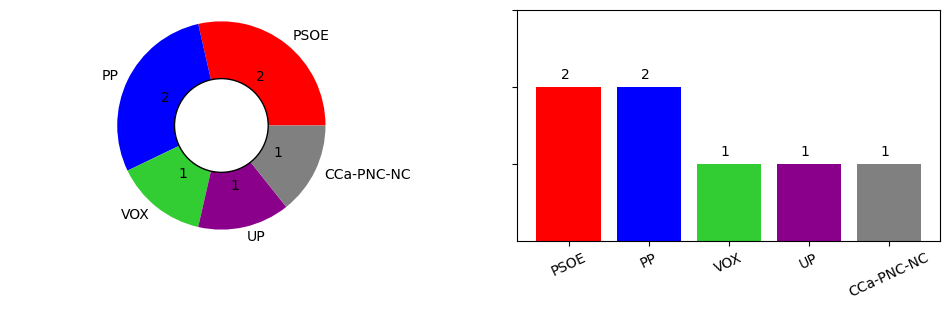

Pontevedra                    7 escaños a repartir


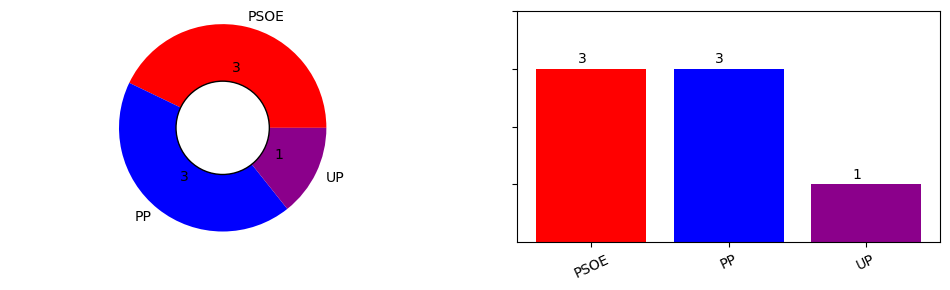

Asturias                      7 escaños a repartir


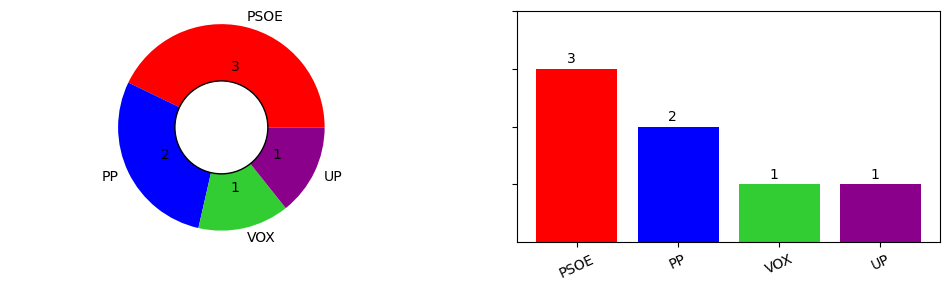

Bizkaia                       8 escaños a repartir


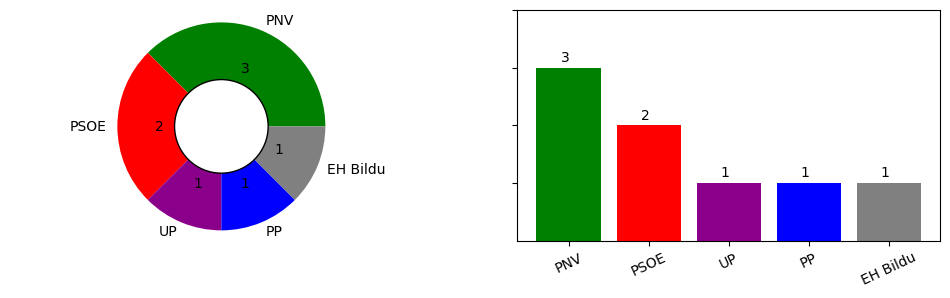

A Coruña                      8 escaños a repartir


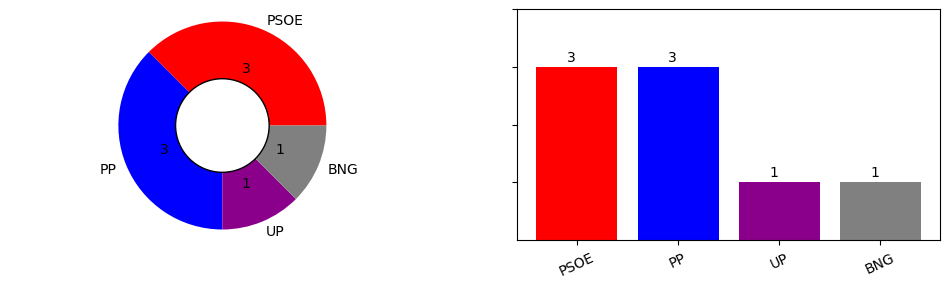

Illes Balears                 8 escaños a repartir


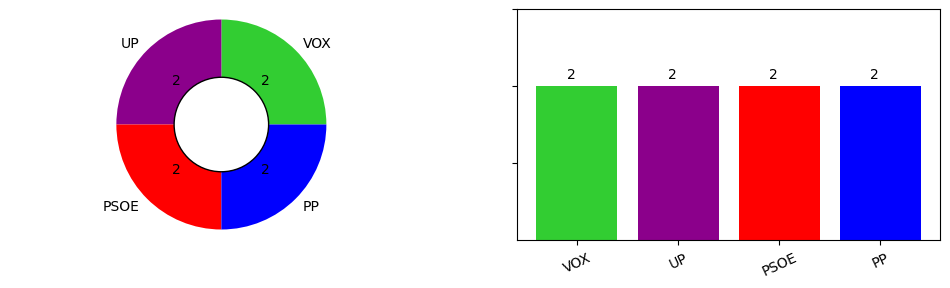

Las Palmas                    8 escaños a repartir


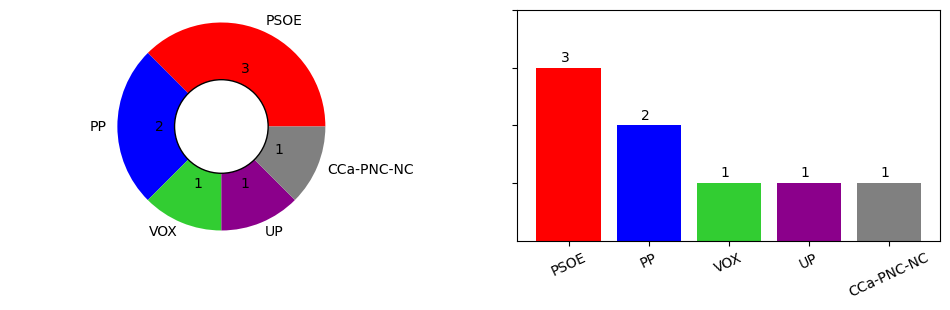

Cádiz                         9 escaños a repartir


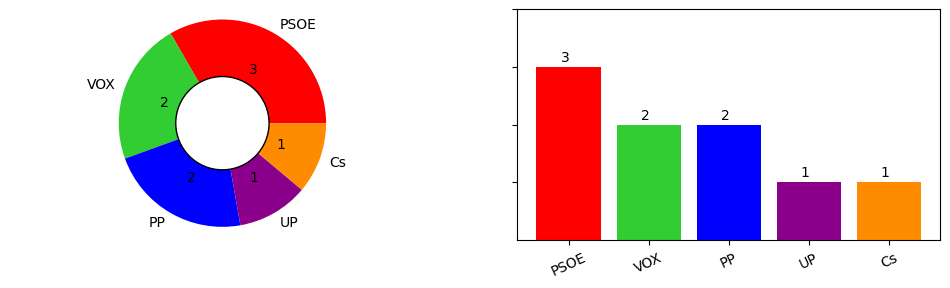

Murcia                        10 escaños a repartir


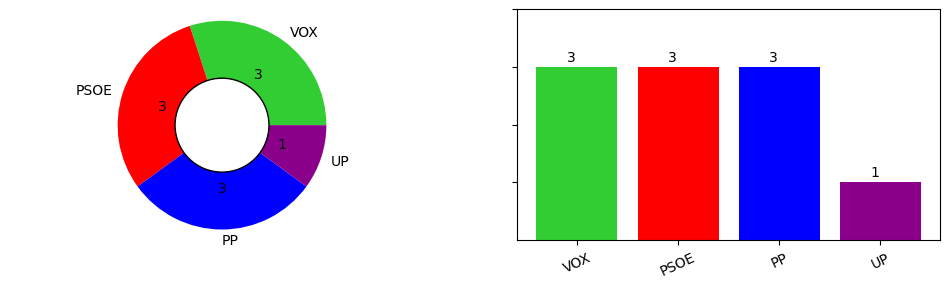

Málaga                        11 escaños a repartir


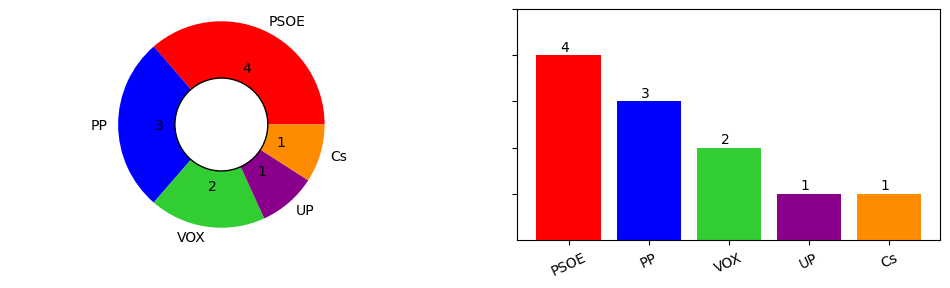

Sevilla                       12 escaños a repartir


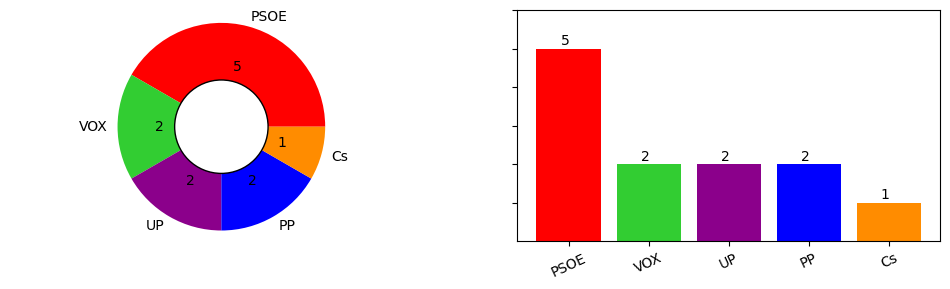

Alicante / Alacant            12 escaños a repartir


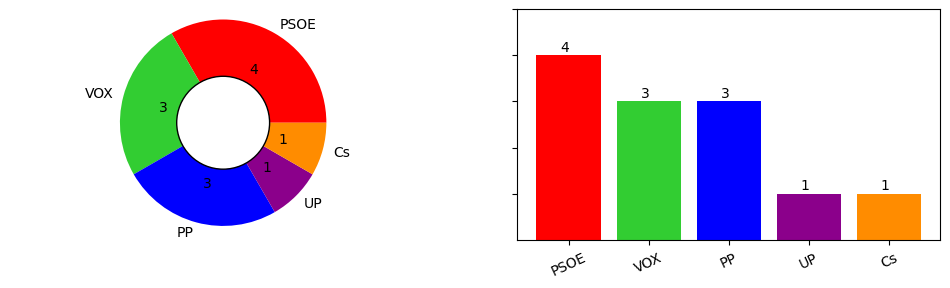

Valencia / València           15 escaños a repartir


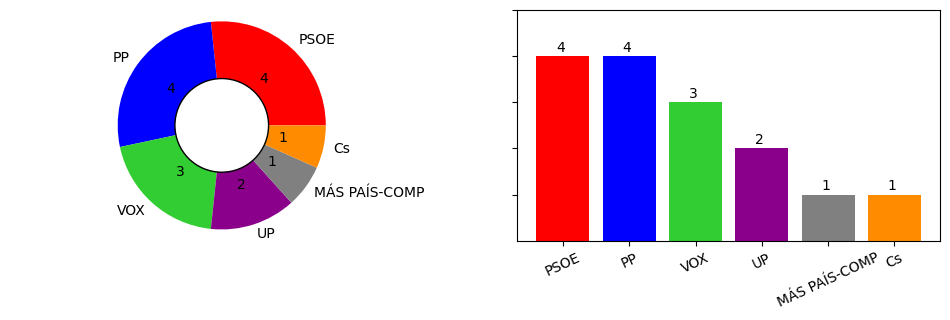

Barcelona                     32 escaños a repartir


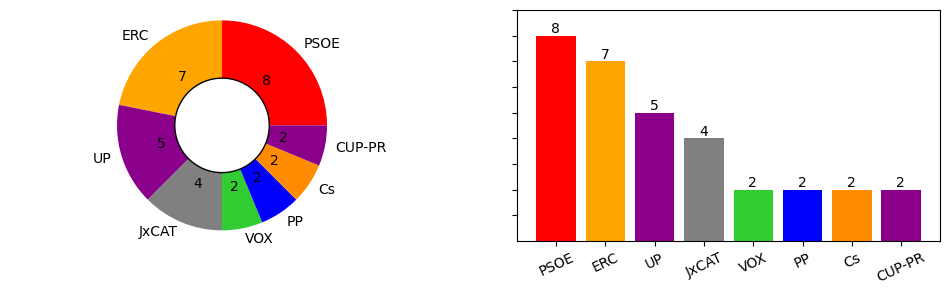

Madrid                        37 escaños a repartir


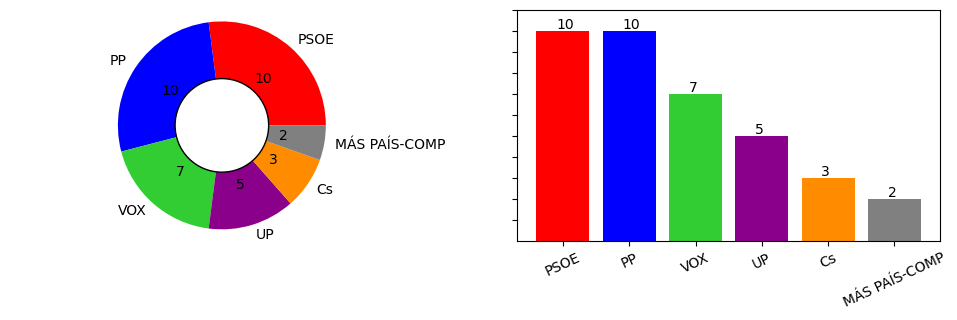

In [21]:
d = {}
for index, row in df.iterrows():
    nomp = row['Nombre de Provincia']
    vv = row['Votos válidos']
    nesc = row['Escaños']
    for partido in row.loc['PSOE':'UDT'].index:
        d[partido] = row[partido]
    resultado = reparto_escaños(vv,nesc,d)
    print(f'{nomp}{nesc} escaños a repartir')
    plot_escaños(resultado)
    

<a id='act6'></a>
## ACTIVIDAD 6: Resultados para el congreso de los diputados

Muestra una gráfica con el total de diputados obtenidos por cada partido al congreso de los diputados. Para ello deberás ir calculando los diputados que ha obtenido cada partido en cada circunscripción, tal y como has hecho en la actividad anterior, e ir acumulando (sumando) dicho número de diputados en otro diccionario. Finalmente, ejecuta la función `plot_escaños` pasándole el diccionario obtenido.

[Volver al índice](#indice)

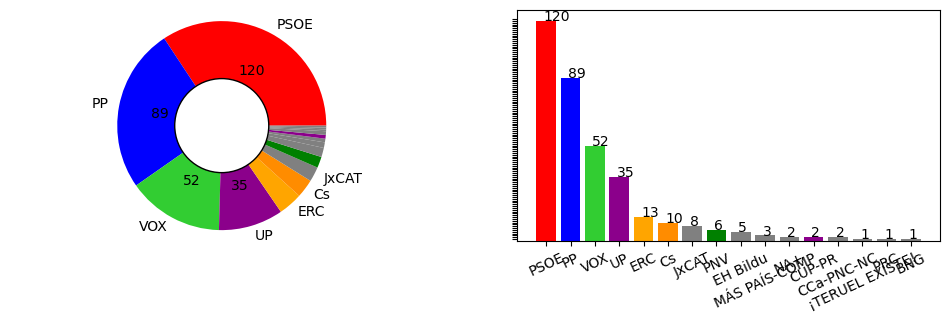

In [17]:
d = {}
e = {}
for index, row in df.iterrows():
    nomp = row['Nombre de Provincia']
    vv = row['Votos válidos']
    nesc = row['Escaños']
    for partido in row.loc['PSOE':'UDT'].index:
        d[partido] = row[partido]
    resultado = reparto_escaños(vv,nesc,d)
    for i in resultado:
        if i not in e:
            e[i] = resultado[i]
        else:
            e[i] += resultado[i]
plot_escaños(e)

<a id='act7'></a>
## ACTIVIDAD 7: Coste en votos de cada escaño

**Conceptos a trabajar:**
- Sumar columnas


**Tareas a realizar:**

En esta actividad vamos a mostrar cuántos votos le cuesta a cada partido obtener un escaño (votos obtenidos / escaños conseguidos). Para ello, realiza las siguientes tareas:


1. A partir del diccionario con los resultados de la actividad anterior, crea otro diccionario que contenga, para cada partido, el total de votos obtenidos entre el número de escaños conseguidos.

1. Muestra una gráfica de barras horizontal con los items de este nuevo diccionario. Dado que el método `ax.barh` trabaja con listas y no con diccionarios, deberás almacenar los valores del diccionario en listas separadas. Para ello puedes utilizar `list(d.keys())` y `list(d.values())` para obtener, respectivamente, las etiquetas y los valores, siendo `d` es el diccionario con los resultados.

1. Añade a la gráfica un grid con líneas verticales y un título, tal y como has hecho en actividades anteriores.

[Volver al índice](#indice)

In [18]:
d = {}
vtot = {}
for i in df.iloc[0].loc['PSOE':'UDT'].index:
        vtot[i] = 0
for index, row in df.iterrows():
    nomp = row['Nombre de Provincia']
    vv = row['Votos válidos']
    nesc = row['Escaños']
    for partido in row.loc['PSOE':'UDT'].index:
        d[partido] = row[partido]
    for i in d:
        vtot[i] += d[i]
c = {}
for i in e:
    c[i] = vtot[i]/e[i]
c

{'PP': 56708.31460674157,
 'VOX': 70326.51923076923,
 'PSOE': 56601.65833333333,
 '¡TERUEL EXISTE!': 19761.0,
 'PNV': 63167.0,
 'UP': 89124.68571428572,
 'EH Bildu': 55524.2,
 'ERC': 67296.84615384616,
 'JxCAT': 66278.125,
 'PRC': 68830.0,
 'NA+': 49539.0,
 'CCa-PNC-NC': 62144.5,
 'BNG': 120456.0,
 'Cs': 165031.8,
 'MÁS PAÍS-COMP': 194102.0,
 'CUP-PR': 123485.5}

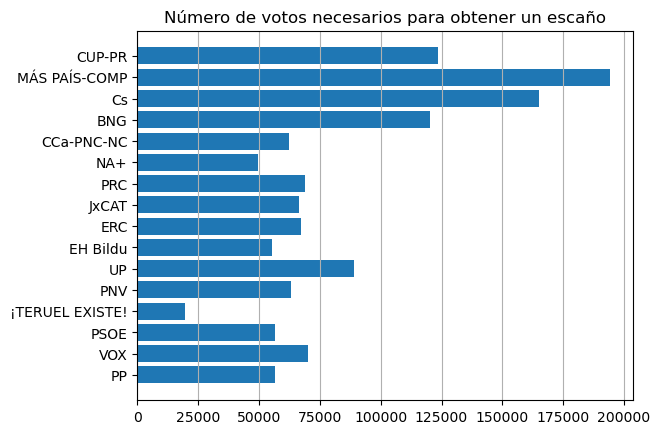

In [19]:
p = list(c.keys())
t = list(c.values())
fig, ax = plt.subplots()
ax.barh(p,t)
ax.grid(axis='x')
ax.set_title('Número de votos necesarios para obtener un escaño')
None